In [5]:
%matplotlib inline

In [24]:
try:
    import alphacsc

except:
    # !pip install alphacsc
    pass

from alphacsc.utils.convolution import construct_X_multi
from alphacsc.viz.epoch import plot_evoked_surrogates
from alphacsc.utils.signal import fast_hilbert
from alphacsc.utils import split_signal
from alphacsc import GreedyCDL

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import mne
import csv
import os

In [12]:
class BenchmarkRun():

    def __init__(self,
                 n_atoms,
                 n_jobs,
                 n_splits,
                 reg,
                 n_times_atom):
        
        self.cdl = None
        
        self.update_run_attributes( n_atoms,
                                    n_jobs,
                                    n_splits,
                                    reg,
                                    n_times_atom)


    def update_run_attributes(self, 
                              n_atoms,
                              n_jobs,
                              n_splits,
                              reg,
                              n_times_atom):
        
        
        self.set_n_jobs(n_jobs)

        self.n_atoms        = n_atoms
        self.n_splits       = n_splits
        self.reg            = reg
        self.n_times_atom   = n_times_atom


    def set_n_jobs(self, n_jobs):

        if n_jobs > os.cpu_count():
            print(f"Tried to assign more jobs ({n_jobs}) than CPU cores ({os.cpu_count()})")
            self.n_jobs = os.cpu_count()
        else:
            self.n_jobs = n_jobs


    def set_n_atoms(self, n_atoms):
        self.n_atoms = n_atoms


    def set_n_split(self, n_splits):
        self.n_splits = n_splits


    def set_reg(self, reg):
        self.reg = reg


    def set_n_times_atom(self, n_times_atom):
        self.n_times_atom = n_times_atom

    def set_cdl(self, cdl):
        self.cdl = cdl
    
    def get_cdl(self):
        return self.cdl
    
    def fit(self, signal, save_results=True):

        self.cdl = GreedyCDL(
            # Shape of the dictionary
            n_atoms=self.n_atoms,
            n_times_atom=self.n_times_atom,
            # Request a rank1 dictionary with unit norm temporal and spatial maps
            rank1=True,
            uv_constraint='separate',
            # apply a temporal window reparametrization
            window=True,
            # at the end, refit the activations with fixed support and no reg to unbias
            unbiased_z_hat=True,
            # Initialize the dictionary with random chunk from the data
            D_init='chunk',
            # rescale the regularization parameter to be a percentage of lambda_max
            lmbd_max="scaled",
            reg=self.reg,
            # Number of iteration for the alternate minimization and cvg threshold
            n_iter=100,
            eps=1e-4,
            # solver for the z-step
            solver_z="lgcd",
            solver_z_kwargs={'tol': 1e-3,
                            'max_iter': 100000},
            # solver for the d-step
            solver_d='alternate_adaptive',
            solver_d_kwargs={'max_iter': 300},
            # sort atoms by explained variances
            sort_atoms=True,
            # Technical parameters
            verbose=1,
            random_state=0,
            n_jobs=self.n_jobs)
    
        start_time = time.time()
        self.cdl.fit(signal)
        fit_time = time.time() - start_time

        if save_results:
            self.write_results(row=[self.n_jobs, self.n_splits, self.n_atoms, self.reg, fit_time]) 


    def write_results(self, row, filename="scaling.csv"):
        filepath = os.path.join( os.path.abspath(''),  filename)

        with open(filepath, "a", newline="") as f:
            csv.writer(f).writerow(row)
        
        

In [ ]:
# sampling frequency. The signal will be resampled to match this.
sfreq = 150.

# Define the shape of the dictionary
n_atoms = 20
n_times_atom = int(round(sfreq * 1.0))  # 1000. ms

# Regularization parameter which control sparsity
reg = 0.1

# number of processors for parallel computing
n_jobs = 32

# Numbers of splits of the signal
n_splits = 16

In [8]:

data_path = mne.datasets.sample.data_path()
subjects_dir = os.path.join(data_path, "subjects")
data_dir = os.path.join(data_path, 'MEG', 'sample')
file_name = os.path.join(data_dir, 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(file_name, preload=True, verbose=False)
raw.pick_types(meg='grad', eeg=False, eog=False, stim=True)


Loading the data...NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
done


In [9]:
# Data preprocessing
raw.notch_filter(np.arange(60, 181, 60), n_jobs=n_jobs, verbose=False)
raw.filter(2, None, n_jobs=n_jobs, verbose=False)
raw = raw.resample(sfreq, npad='auto', n_jobs=n_jobs, verbose=False)

X = raw.get_data(picks=['meg'])
info = raw.copy().pick_types(meg=True).info  # info of the loaded channels
X_split = split_signal(X, n_splits=n_splits, apply_window=True) # use a tukey window to scale down the border of each split

Preprocessing the data...done


C:\Users\gaumu\AppData\Local\Temp\ipykernel_32824\2776348727.py:4: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw = raw.resample(sfreq, npad='auto', n_jobs=n_jobs, verbose=False)


Fit the model and learn rank1 atoms



In [11]:

run = BenchmarkRun(n_atoms=n_atoms, n_jobs=n_jobs, n_times_atom=n_times_atom, reg=reg, n_splits=n_splits)

list_jobs = [1, 2, 4, 6, 8]

for j in list_jobs:
    print(f"Running with '{j}' cores")
    run.set_n_jobs(j)
    run.fit(X_split)

run.set_n_jobs(os.cpu_count())

list_n_splits = [2, 4, 8, 16, 32]

for j in list_n_splits:
    print(f"Running with '{j}' splits")
    run.set_n_split(j)
    run.fit(X_split)

..........
[GreedyCDL] Converged after 10 iteration, (dz, du) = 7.132e-05, 5.563e-05
[GreedyCDL] Fit in 15.9s
..........
[GreedyCDL] Converged after 10 iteration, (dz, du) = 7.132e-05, 5.563e-05
[GreedyCDL] Fit in 12.1s
..........
[GreedyCDL] Converged after 10 iteration, (dz, du) = 7.132e-05, 5.563e-05
[GreedyCDL] Fit in 9.3s
..........
[GreedyCDL] Converged after 10 iteration, (dz, du) = 7.132e-05, 5.563e-05
[GreedyCDL] Fit in 8.4s
..........
[GreedyCDL] Converged after 10 iteration, (dz, du) = 7.132e-05, 5.563e-05
[GreedyCDL] Fit in 8.0s
..........
[GreedyCDL] Converged after 10 iteration, (dz, du) = 7.132e-05, 5.563e-05
[GreedyCDL] Fit in 8.1s


Text(0, 0.5, 'Time (s)')

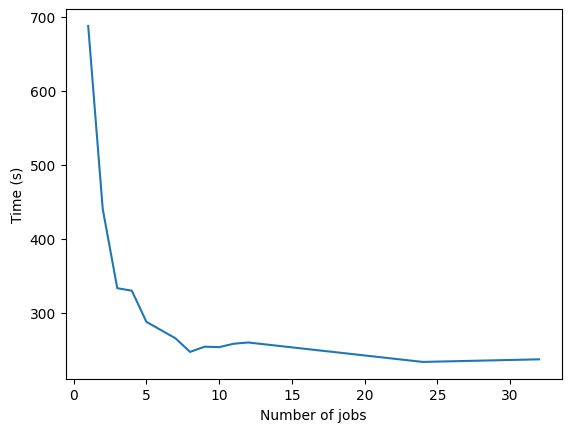

In [34]:
result_jobs  = pd.read_csv("scaling_jobs.csv")
result_split = pd.read_csv("scaling_splits.csv")


plt.plot( result_jobs["n_jobs"], result_jobs["time"] )
plt.xlabel("Number of jobs")
plt.ylabel("Time (s)")

In [108]:
cdl = run.get_cdl()
z_hat = cdl.transform(X[None, :]) # recover sparse codes associated with X (we use it on the unsplit data so the sparse codes reflect the orignal data)

Refitting the activation to avoid amplitude bias...done


Displayed 5 atomstom                      


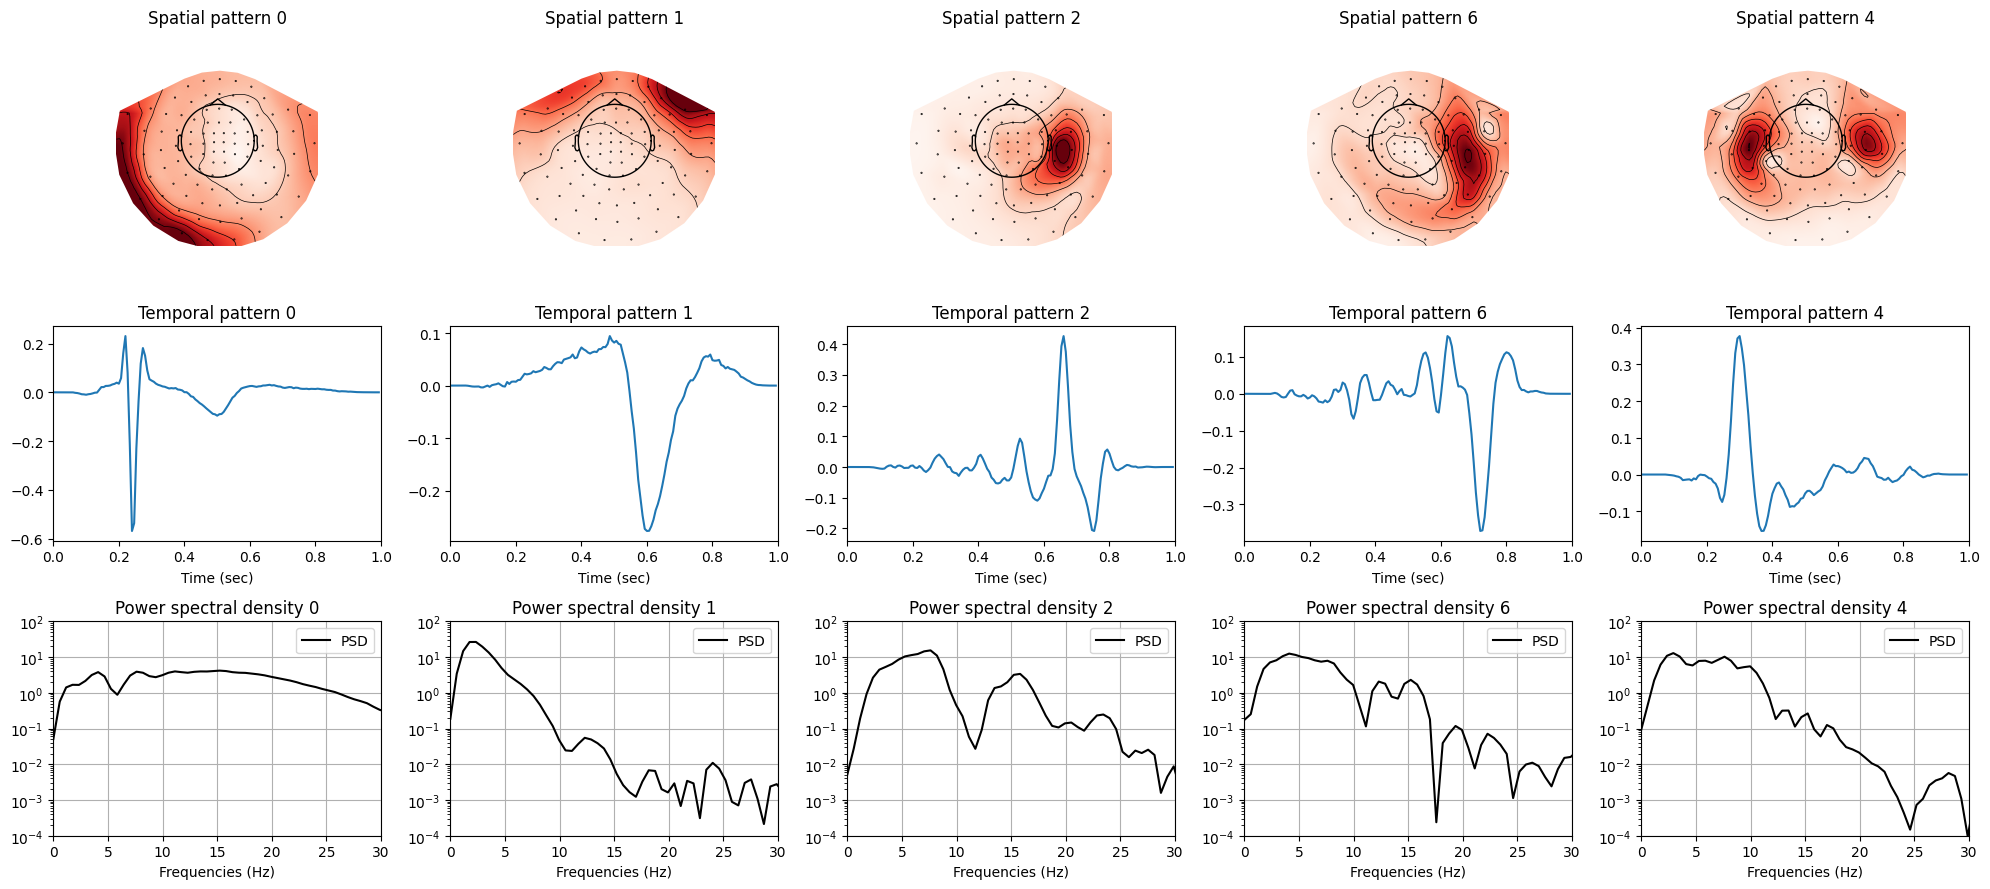

In [109]:
import matplotlib.pyplot as plt

plotted_atoms = [0, 1, 2, 6, 4]

n_plots = 3  # number of plots by atom
n_columns = min(6, len(plotted_atoms))
split = int(np.ceil(len(plotted_atoms) / n_columns))
figsize = (4 * n_columns, 3 * n_plots * split)
fig, axes = plt.subplots(n_plots * split, n_columns, figsize=figsize)
for ii, kk in enumerate(plotted_atoms):

    # Select the axes to display the current atom
    print("\rDisplaying {}-th atom".format(kk), end='', flush=True)
    i_row, i_col = ii // n_columns, ii % n_columns
    it_axes = iter(axes[i_row * n_plots:(i_row + 1) * n_plots, i_col])

    # Select the current atom
    u_k = cdl.u_hat_[kk]
    v_k = cdl.v_hat_[kk]

    # Plot the spatial map of the atom using mne topomap
    ax = next(it_axes)
    mne.viz.plot_topomap(u_k, info, axes=ax, show=False)
    ax.set(title="Spatial pattern %d" % (kk, ))

    # Plot the temporal pattern of the atom
    ax = next(it_axes)
    t = np.arange(n_times_atom) / sfreq
    ax.plot(t, v_k)
    ax.set_xlim(0, n_times_atom / sfreq)
    ax.set(xlabel='Time (sec)', title="Temporal pattern %d" % kk)

    # Plot the power spectral density (PSD)
    ax = next(it_axes)
    psd = np.abs(np.fft.rfft(v_k, n=256)) ** 2
    frequencies = np.linspace(0, sfreq / 2.0, len(psd))
    ax.semilogy(frequencies, psd, label='PSD', color='k')
    ax.set(xlabel='Frequencies (Hz)', title="Power spectral density %d" % kk)
    ax.grid(True)
    ax.set_xlim(0, 30)
    ax.set_ylim(1e-4, 1e2)
    ax.legend()
    


fig.tight_layout()

In [110]:
event_id = [1, 2, # auditory stimuli
            3, 4] # visual stimuli
events = mne.find_events(raw, stim_channel='STI 014')
events = mne.pick_events(events, include=event_id)
events[:, 0] -= raw.first_samp

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


Displaying 0-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 70 events and 91 original time points ...
0 bad epochs dropped
Displaying 1-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 73 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 70 events and 91 original time points ...
0 bad epochs dropped
Displaying 2-th atom envelopeUsing data from preloaded Raw for 72 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 73 eve

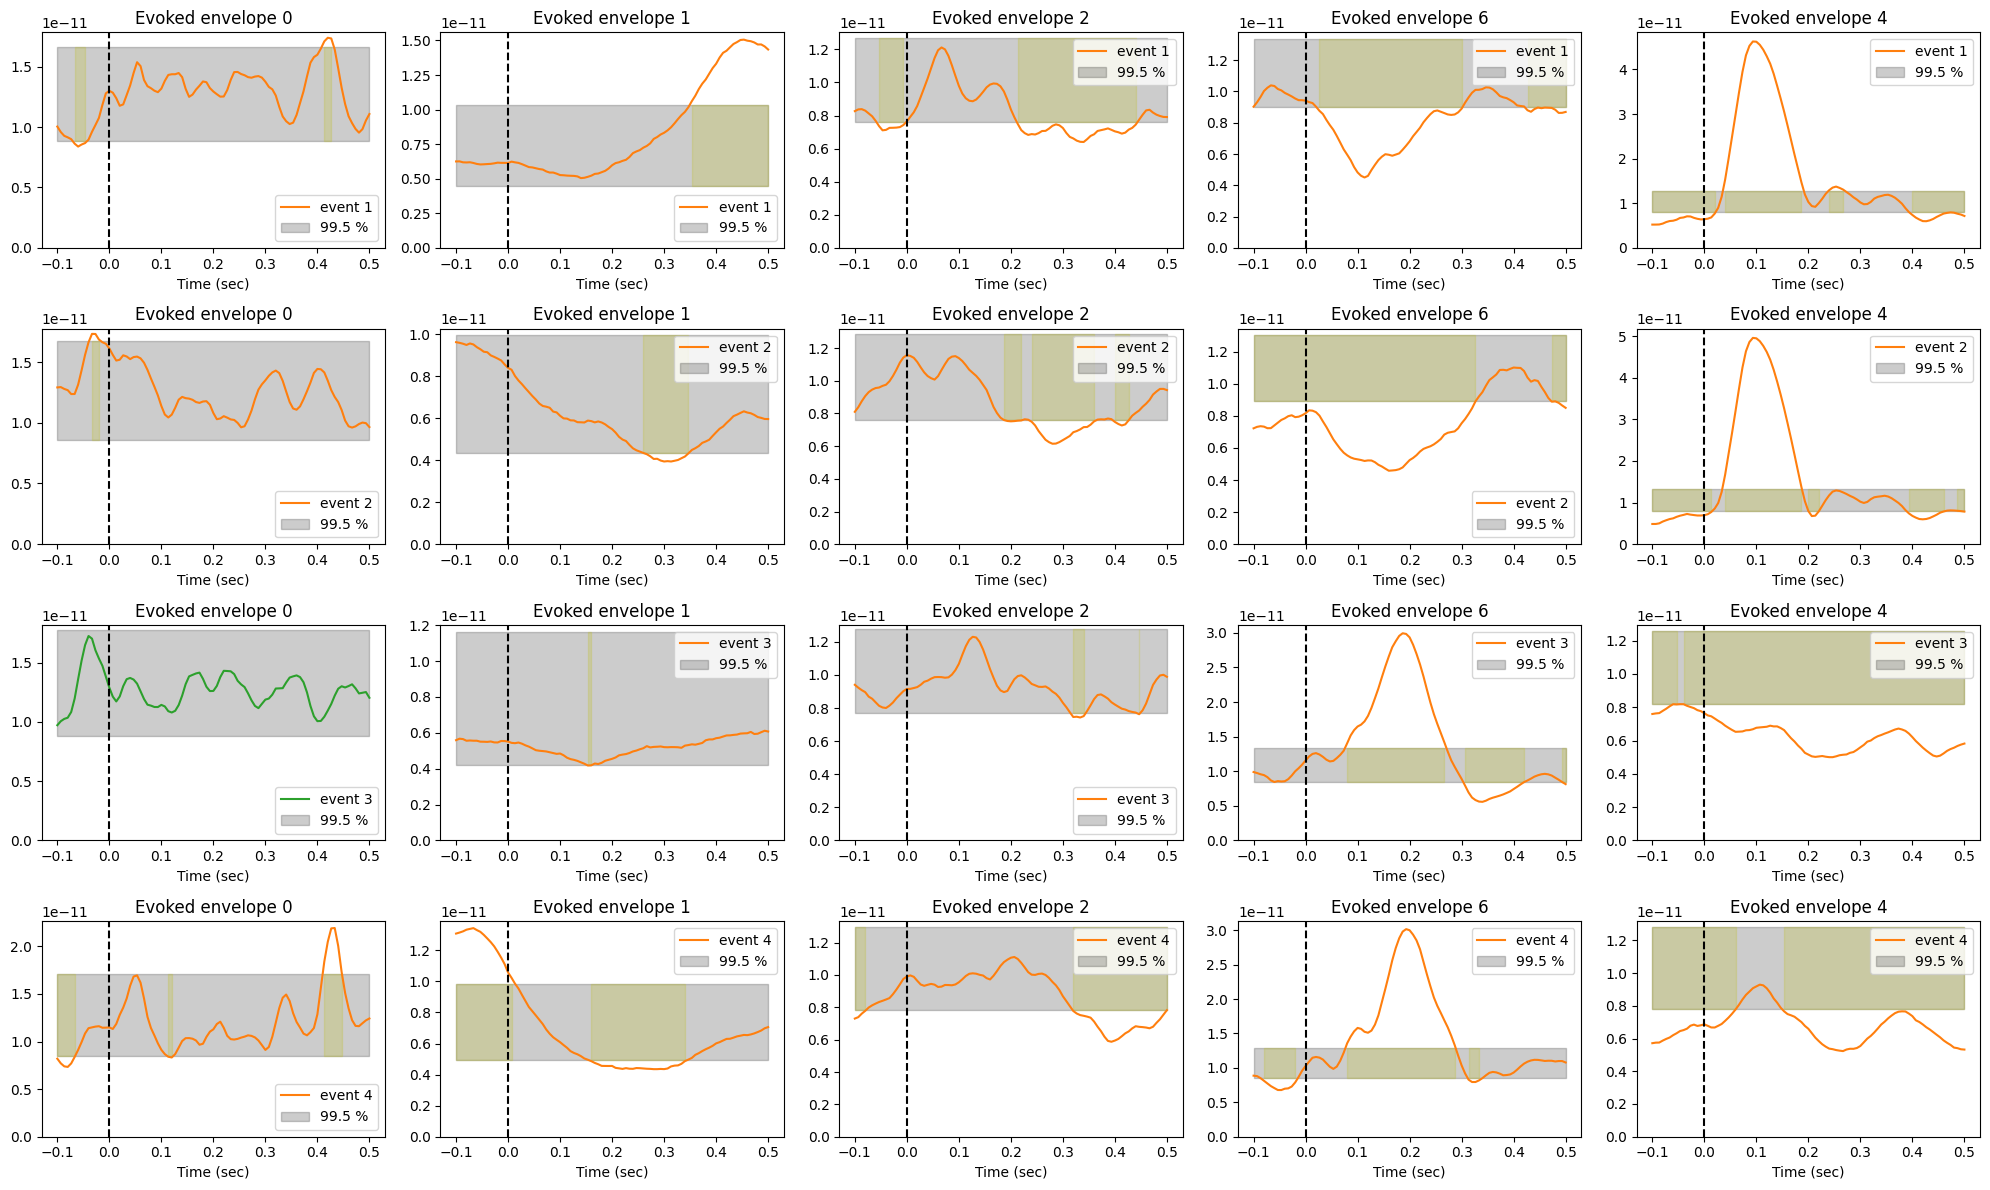

In [111]:


# time window around the events. 
t_lim = (-0.1, 0.5)

n_plots = len(event_id)
n_columns = min(6, len(plotted_atoms))
split = int(np.ceil(len(plotted_atoms) / n_columns))
figsize = (4 * n_columns, 3 * n_plots * split)
fig, axes = plt.subplots(n_plots * split, n_columns, figsize=figsize)

for ii, kk in enumerate(plotted_atoms):

    # Select the axes to display the current atom
    print("\rDisplaying {}-th atom envelope".format(kk), end='', flush=True)
    i_row, i_col = ii // n_columns, ii % n_columns
    it_axes = iter(axes[i_row * n_plots:(i_row + 1) * n_plots, i_col])

    # Select the current atom
    v_k = cdl.v_hat_[kk]
    v_k_1 = np.r_[[1], v_k][None]
    z_k = z_hat[:, kk:kk + 1]
    X_k = construct_X_multi(z_k, v_k_1, n_channels=1)[0, 0]

    # compute the 'envelope' of the reconstructed signal X_k
    correlation = np.abs(fast_hilbert(X_k))

    # loop over all events IDs
    for this_event_id in event_id:
        this_events = events[events[:, 2] == this_event_id]
        # plotting function
        ax = next(it_axes)
        this_info = info.copy()
        event_info = dict(event_id = this_event_id, events=events)
        this_info['temp'] = event_info
        plot_evoked_surrogates(correlation, info=this_info, t_lim=t_lim, ax=ax,
                               n_jobs=n_jobs, label='event %d' % this_event_id)
        ax.set(xlabel='Time (sec)', title="Evoked envelope %d" % kk)
print("\rDisplayed {} atoms".format(len(plotted_atoms)).rjust(40))
fig.tight_layout()

In [112]:
subjects_dir = os.path.join(data_path, 'subjects')
fname_bem = os.path.join(subjects_dir, 'sample', 'bem',
                         'sample-5120-bem-sol.fif')
fname_trans = os.path.join(data_path, 'MEG', 'sample',
                           'sample_audvis_raw-trans.fif')
fname_cov = os.path.join(data_path, 'MEG', 'sample', 'sample_audvis-cov.fif')
evoked = mne.EvokedArray(cdl.u_hat_.T, info)
dip = mne.fit_dipole(evoked, fname_cov, fname_bem, fname_trans,
                     n_jobs=n_jobs, verbose=False)[0]

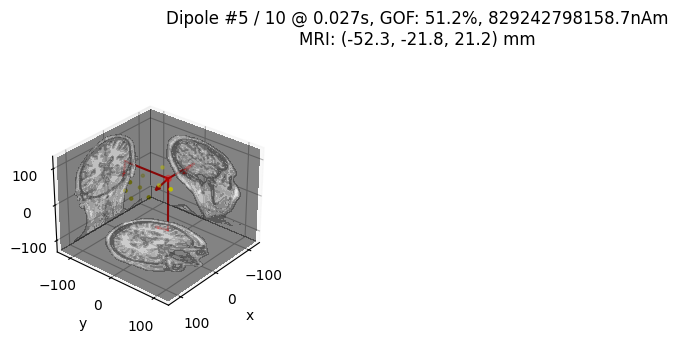

In [115]:
atom_dipole_idx = 4

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 4))

# Display the dipole fit
ax = fig.add_subplot(1, 3, 1, projection='3d')
dip.plot_locations(fname_trans, 'sample', subjects_dir, idx=atom_dipole_idx,
                   ax=ax)
ax.set_title('Atom #{} (GOF {:.2f}%)'.format(atom_dipole_idx,
                                             dip.gof[atom_dipole_idx]))

# Plot the spatial map
ax = fig.add_subplot(1, 3, 2)
mne.viz.plot_topomap(cdl.u_hat_[atom_dipole_idx], info, axes=ax)

# Plot the temporal atom
ax = fig.add_subplot(1, 3, 3)
t = np.arange(n_times_atom) / sfreq
ax.plot(t, cdl.v_hat_[atom_dipole_idx])
ax.set_xlim(0, n_times_atom / sfreq)
ax.set(xlabel='Time (sec)', title="Temporal pattern {}"
       .format(atom_dipole_idx))

fig.suptitle('')
fig.tight_layout()